# Trajectory planning problem

Set up the trajectory planning problem with:
  1. start and end points
  2. known obstacles
  3. unknown obstacles
  
Goal:
  1. reach the end point
  1. then, do so as efficiently as possible (add optimization objective)
  
Initial setup:
  1. use RRT or some basic path planning algorithm
  2. once an objective must be optimized for, move to CHOMP (or something along those lines)
  
Initial feedback methods:
  1. baseline: if a path conflicts, get point at which it conflicts
  2. baseline: if a path conflicts, get no additional information other than it is in violation
  3. (to implement) baseline: bayesian prior on trajectory space updated with preference queries

In [1]:
# maps and algorithms adapted from Atsushi Sakai (@Atsushi_twi) and Anca Dragan/Andreea Bobu
# preliminaries
%matplotlib inline
import random
import time
import math
import numpy as np
from scipy import stats
import scipy.spatial
import matplotlib.pyplot as plt
from IPython import display

In [43]:
# Probablistic Road Map (PRM) Planner
# Modified from code by Atsushi Sakai (@Atsushi_twi)

N_KNN = 10  # number of edges from one sampled point
MAX_EDGE_LEN = 30.0  # [m] Maximum edge length

class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, pind):
        self.x = x
        self.y = y
        self.cost = cost
        self.pind = pind

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.pind)


class KDTree:
    """
    Nearest neighbor search class with KDTree
    """

    def __init__(self, data):
        # store kd-tree
        self.tree = scipy.spatial.cKDTree(data)

    def search(self, inp, k=1):
        """
        Search NN
        inp: input data, single frame or multi frame
        """

        if len(inp.shape) >= 2:  # multi input
            index = []
            dist = []

            for i in inp.T:
                idist, iindex = self.tree.query(i, k=k)
                index.append(iindex)
                dist.append(idist)

            return index, dist

        dist, index = self.tree.query(inp, k=k)
        return index, dist

    def search_in_distance(self, inp, r):
        """
        find points with in a distance r
        """

        index = self.tree.query_ball_point(inp, r)
        return index


def PRM_planning(start_x, start_y, goal_x, goal_y, obstacle_x, obstacle_y, rr, 
                 num_samples, show_animation, show_roadmap):

    obkdtree = KDTree(np.vstack((obstacle_x, obstacle_y)).T)

    sample_x, sample_y = sample_points(start_x, start_y, goal_x, goal_y, rr, obstacle_x, obstacle_y, obkdtree, num_samples)
    if show_animation:
        plt.plot(sample_x, sample_y, ".b")

    road_map = generate_roadmap(sample_x, sample_y, rr, obkdtree, show_roadmap)

    rx, ry = dijkstra_planning(
        start_x, start_y, goal_x, goal_y, obstacle_x, obstacle_y, rr, road_map, sample_x, sample_y, show_animation)

    return rx, ry


def is_collision(start_x, start_y, goal_x, goal_y, rr, okdtree, return_conflict_point=False):
    x = start_x
    y = start_y
    dx = goal_x - start_x
    dy = goal_y - start_y
    yaw = math.atan2(goal_y - start_y, goal_x - start_x)
    d = math.hypot(dx, dy)

    if d >= MAX_EDGE_LEN:
        return True

    D = rr
    nstep = round(d / D)

    for i in range(nstep):
        idxs, dist = okdtree.search(np.array([x, y]).reshape(2, 1))
        if dist[0] <= rr:
            if return_conflict_point:
                return True, (x, y)
            else:
                return True  # collision
        x += D * math.cos(yaw)
        y += D * math.sin(yaw)

    # goal point check
    idxs, dist = okdtree.search(np.array([goal_x, goal_y]).reshape(2, 1))
    if dist[0] <= rr:
        if return_conflict_point:
            return True, (goal_x, goal_y)
        else:
            return True  # collision
    if return_conflict_point:
        return False, None
    return False  # OK


def generate_roadmap(sample_x, sample_y, rr, obkdtree, show_roadmap):
    """
    Road map generation
    sample_x: [m] x positions of sampled points
    sample_y: [m] y positions of sampled points
    rr: Robot Radius[m]
    obkdtree: KDTree object of obstacles
    """

    road_map = []
    nsample = len(sample_x)
    skdtree = KDTree(np.vstack((sample_x, sample_y)).T)

    for (i, ix, iy) in zip(range(nsample), sample_x, sample_y):

        index, dists = skdtree.search(
            np.array([ix, iy]).reshape(2, 1), k=nsample)
        inds = index[0]
        edge_id = []
        #  print(index)

        for ii in range(1, len(inds)):
            nx = sample_x[inds[ii]]
            ny = sample_y[inds[ii]]

            if not is_collision(ix, iy, nx, ny, rr, obkdtree):
                edge_id.append(inds[ii])

            if len(edge_id) >= N_KNN:
                break

        road_map.append(edge_id)

    if show_roadmap:
        plot_road_map(road_map, sample_x, sample_y)

    return road_map


def dijkstra_planning(start_x, start_y, goal_x, goal_y, obstacle_x, 
                    obstacle_y, rr, road_map, sample_x, sample_y,
                     show_animation):
    """
    start_x: start x position [m]
    start_y: start y position [m]
    goal_x: goal x position [m]
    goal_y: goal y position [m]
    obstacle_x: x position list of Obstacles [m]
    obstacle_y: y position list of Obstacles [m]
    rr: robot radius [m]
    road_map: ??? [m]
    sample_x: ??? [m]
    sample_y: ??? [m]
    @return: Two lists of path coordinates ([x1, x2, ...], [y1, y2, ...]), empty list when no path was found
    """

    nstart = Node(start_x, start_y, 0.0, -1)
    ngoal = Node(goal_x, goal_y, 0.0, -1)

    openset, closedset = dict(), dict()
    openset[len(road_map) - 2] = nstart

    path_found = True

    while True:
        if not openset:
            path_found = False
            break

        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]

        # show graph
        if show_animation and len(closedset.keys()) % 2 == 0:
            plt.plot(current.x, current.y, "xg")

        if c_id == (len(road_map) - 1):
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = math.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closedset:
                continue
            # Otherwise if it is already in the open set
            if n_id in openset:
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id
            else:
                openset[n_id] = node

    if path_found is False:
        return [], []

    # generate final course
    rx, ry = [ngoal.x], [ngoal.y]
    pind = ngoal.pind
    while pind != -1:
        n = closedset[pind]
        rx.append(n.x)
        ry.append(n.y)
        pind = n.pind

    return rx, ry


def plot_road_map(road_map, sample_x, sample_y):  # pragma: no cover

    for i, _ in enumerate(road_map):
        for ii in range(len(road_map[i])):
            ind = road_map[i][ii]

            plt.plot([sample_x[i], sample_x[ind]],
                     [sample_y[i], sample_y[ind]], "-k")


def sample_points(start_x, start_y, goal_x, goal_y, rr, obstacle_x, obstacle_y, obkdtree, num_samples):
    maxx = max(obstacle_x)
    maxy = max(obstacle_y)
    minx = min(obstacle_x)
    miny = min(obstacle_y)

    sample_x, sample_y = [], []

    while len(sample_x) <= num_samples:
        tx = (random.random() * (maxx - minx)) + minx
        ty = (random.random() * (maxy - miny)) + miny

        index, dist = obkdtree.search(np.array([tx, ty]).reshape(2, 1))

        if dist[0] >= rr:
            sample_x.append(tx)
            sample_y.append(ty)

    sample_x.append(start_x)
    sample_y.append(start_y)
    sample_x.append(goal_x)
    sample_y.append(goal_y)

    return sample_x, sample_y

def get_obstacles():
    obstacle_xs = []
    obstacle_ys = []

    for i in range(60):
        obstacle_xs.append(i)
        obstacle_ys.append(0.0)
    for i in range(60):
        obstacle_xs.append(60.0)
        obstacle_ys.append(i)
    for i in range(61):
        obstacle_xs.append(i)
        obstacle_ys.append(60.0)
    for i in range(61):
        obstacle_xs.append(0.0)
        obstacle_ys.append(i)
    for i in range(30):
        obstacle_xs.append(20.0)
        obstacle_ys.append(i)
    for i in range(30):
        obstacle_xs.append(40.0)
        obstacle_ys.append(60.0 - i)

    return obstacle_xs, obstacle_ys

def get_obstacles_hidden():
    obstacle_xs = []
    obstacle_ys = []
    for i in range(27, 33):
        for j in [30, 20]:
            obstacle_xs.append(i)
            obstacle_ys.append(j)
    for j in range(10, 25):
        obstacle_xs.append(40)
        obstacle_ys.append(j)
    

    return obstacle_xs, obstacle_ys

def prm(num_samples, obstacle_xs, obstacle_ys, start_x=10, start_y=10, 
        goal_x=50, goal_y=50, show_animation=False, show_roadmap=False, hidden_xs=None, hidden_ys=None, robot_size = 5.0):
      # [m]
    
    if show_animation:
        if hidden_xs is not None and hidden_ys is not None:
            plt.plot(hidden_xs, hidden_ys, ".m")
        plt.plot(obstacle_xs, obstacle_ys, ".k")
        plt.plot(start_x, start_y, "^r")
        plt.plot(goal_x, goal_y, "^c")
        plt.grid(True)
        plt.axis("equal")

    rx, ry = PRM_planning(start_x, start_y, goal_x, goal_y, obstacle_xs, obstacle_ys, 
                          robot_size, num_samples, show_animation, show_roadmap)

    if len(rx) > 0 and show_animation:
        plt.plot(rx, ry, "-r")
        plt.show()
        
    return rx, ry

def check_path_validity(path, hidden_obstacle_x, hidden_obstacle_y, rr=5, verbosity=0):
    # given a solution candidate that is consistent with the known constraints,
    # check whether or not it's valid with the unknown constraints
    path_x, path_y = path
    obkdtree = KDTree(np.vstack((hidden_obstacle_x, hidden_obstacle_y)).T)
    for pathidx in range(1, len(path_x)):
        current_start = path_x[pathidx - 1], path_y[pathidx - 1]
        current_stop = path_x[pathidx], path_y[pathidx]
        conflict, cpt = is_collision(current_start[0], current_start[1], current_stop[0], current_stop[1], rr, obkdtree, return_conflict_point=True)
        if conflict:
            return False, cpt
    return True, None
            
            

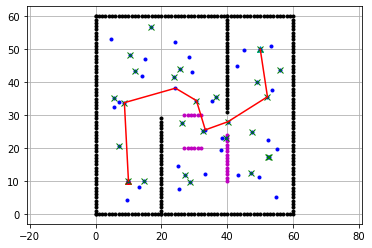

Checking validity of path wrt hidden obstacles:
Proposed solution's validity is False
Point along path in conflict is (32.45729543887475, 28.38044770607257)


In [52]:
obstacle_hidden_xs, obstacle_hidden_ys = get_obstacles_hidden()
obstacle_xs, obstacle_ys = get_obstacles()
goal_position = (50, 50)
robot_radius = 3

path_50 = prm(num_samples=50, obstacle_xs=obstacle_xs, obstacle_ys=obstacle_ys, show_animation=True, hidden_xs=obstacle_hidden_xs, hidden_ys = obstacle_hidden_ys,
             robot_size=robot_radius)
path_x, path_y = path_50
path_found = True
if len(path_x) == 0 or (path_x[0], path_y[0]) != goal_position:
    print("Failure to construct initially valid path")
    path_found = False
if path_found:
    isvalid, conflict_pt = check_path_validity(path_50, obstacle_hidden_xs, obstacle_hidden_ys, rr=robot_radius, verbosity=1) 

    print("Checking validity of path wrt hidden obstacles:")
    print("Proposed solution's validity is {}".format(isvalid))
    if not isvalid:
        print("Point along path in conflict is {}".format(conflict_pt))

In [55]:
# now, implement some basic methods of gathering information from solution candidates
obstacle_hidden_xs, obstacle_hidden_ys = get_obstacles_hidden()
obstacle_xs, obstacle_ys = get_obstacles()

def iterate_on_conflicting_points(obstacle_xs, obstacle_ys, obstacle_hidden_xs, obstacle_hidden_ys, num_samples=50, max_iters=20):
    citer = 0
    while citer < max_iters: 
        current_path = prm(num_samples=50, obstacle_xs=obstacle_xs, obstacle_ys=obstacle_ys, show_animation=False, hidden_xs=obstacle_hidden_xs, hidden_ys = obstacle_hidden_ys,
                           robot_size=robot_radius)
        if len(path_x) == 0 or (path_x[0], path_y[0]) != goal_position:
            # did not find a valid path in the first place
            citer += 1
            continue
        isvalid, conflict_pt = check_path_validity(current_path, obstacle_hidden_xs, obstacle_hidden_ys, rr=robot_radius, verbosity=1)
        if isvalid:
            print("Valid path found in {} iterations.".format(citer))
            return current_path
        # add conflicting point to our obstacles
        obstacle_xs.append(conflict_pt[0])
        obstacle_ys.append(conflict_pt[1])
        citer += 1
    print("Could not find valid path in {} iterations".format(citer))
    return None
    
valid_path = iterate_on_conflicting_points(obstacle_xs, obstacle_ys, obstacle_hidden_xs, obstacle_hidden_ys)

Valid path found in 6 iterations.
